In [2]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
fonts-nanum is already the newest version (20200506-1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 12 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/

In [3]:
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic')

In [4]:
!pip install keras-cv

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, DenseNet121, EfficientNetB0, MobileNetV2, VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Conv2DTranspose
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models
import pathlib
import os
import datetime
import time
import keras_cv

In [6]:
# 데이터셋 다운로드 및 준비
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, fname='flower_photos', untar=True)
data_dir = pathlib.Path(data_dir)

# 현재 데이터 경로 확인
print("데이터셋 경로:", data_dir)

# 폴더 구조 확인 (문제 파악용)
print("폴더 내 항목:", [item.name for item in data_dir.glob('*')])

# 실제 꽃 이미지가 있는 폴더로 경로 수정
if 'flower_photos' in [item.name for item in data_dir.glob('*')]:
    data_dir = data_dir / 'flower_photos'
    print("수정된 데이터셋 경로:", data_dir)

# 클래스 확인
flowers_classes = [item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]
print("꽃 종류:", flowers_classes)
print("클래스 수:", len(flowers_classes))

# 이미지 개수 확인
image_count = len(list(data_dir.glob('*/*.jpg')))
print("전체 이미지 개수:", image_count)

# 클래스별 이미지 개수 확인
for flower in flowers_classes:
    flower_count = len(list(data_dir.glob(f'{flower}/*.jpg')))
    print(f"{flower}: {flower_count}개")

batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)
class_names = train_ds.class_names
num_classes = len(class_names)

# 데이터 증강 및 전처리
normalization_layer = layers.Rescaling(1./255)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

데이터셋 경로: /root/.keras/datasets/flower_photos
폴더 내 항목: ['flower_photos']
수정된 데이터셋 경로: /root/.keras/datasets/flower_photos/flower_photos
꽃 종류: ['sunflowers', 'tulips', 'roses', 'daisy', 'dandelion']
클래스 수: 5
전체 이미지 개수: 3670
sunflowers: 699개
tulips: 799개
roses: 641개
daisy: 633개
dandelion: 898개
Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [7]:
def count_images_per_class(dataset, class_names):
    class_counts = {class_name: 0 for class_name in class_names}
    for images, labels in dataset:
        for label in labels.numpy():
            class_counts[class_names[label]] += 1
    return class_counts

print("Training dataset image counts per class:")
train_counts = count_images_per_class(train_ds, class_names)
for class_name, count in train_counts.items():
    print(f"{class_name}: {count}개")

print("\nValidation dataset image counts per class:")
val_counts = count_images_per_class(val_ds, class_names)
for class_name, count in val_counts.items():
    print(f"{class_name}: {count}개")

Training dataset image counts per class:
daisy: 504개
dandelion: 722개
roses: 521개
sunflowers: 547개
tulips: 642개

Validation dataset image counts per class:
daisy: 129개
dandelion: 176개
roses: 120개
sunflowers: 152개
tulips: 157개


In [8]:
def build_attention_cnn():
    inputs = keras.Input(shape=(img_height, img_width, 3))
    x = normalization_layer(inputs)

    x = layers.Conv2D(32, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Conv2D(64, 3, activation='relu')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.LayerNormalization()(x)

    # Reshape for Attention
    shape = tf.keras.backend.int_shape(x)
    x = layers.Reshape((shape[1] * shape[2], shape[3]))(x)

    # Attention 설정
    x = layers.MultiHeadAttention(num_heads=2, key_dim=16)(x, x)
    x = layers.GlobalAveragePooling1D()(x)

    # Dense 레이어
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


Evaluating and plotting Attention-CNN ...


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        896 │ rescaling[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 111, 111,  │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 54, 54,    │        128 │ max_pooling2d_1[… │
│ (LayerNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 2916, 64)  │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2916, 64)  │      8,352 │ reshape[0][0],    │
│ (MultiHeadAttentio… │                   │            │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ multi_head_atten… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │        325 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 32,357 (126.39 KB)

 Trainable params: 32,357 (126.39 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 43s 337ms/step - accuracy: 0.2953 - loss: 1.5266 - val_accuracy: 0.5027 - val_loss: 1.1377
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 209ms/step - accuracy: 0.4958 - loss: 1.2179 - val_accuracy: 0.5381 - val_loss: 1.1026
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 210ms/step - accuracy: 0.5367 - loss: 1.1035 - val_accuracy: 0.5763 - val_loss: 1.0325
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 212ms/step - accuracy: 0.5716 - loss: 1.0563 - val_accuracy: 0.5504 - val_loss: 1.0327
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.5972 - loss: 0.9999 - val_accuracy: 0.6390 - val_loss: 0.8882
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - accuracy: 0.6190 - loss: 0.9723 - val_accuracy: 0.6757 - val_loss: 0.8597
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 214ms/step - accuracy: 0.6400 - loss: 0.9245 - val_accuracy: 0.6199 - val_loss: 0.9385
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 20s 215ms/step - accuracy: 0.6805 - loss: 0.8358 - 

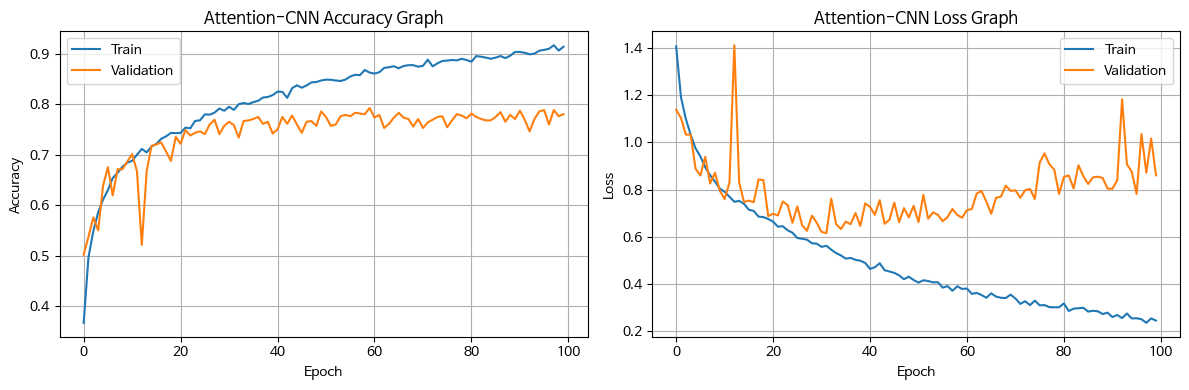

In [9]:
model_builders = {
        "Attention-CNN": build_attention_cnn
}

results = []
all_results = []
EPOCHS = 100

# 모델별 훈련 및 평가
for name, builder in model_builders.items():
    print(f"Evaluating and plotting {name} ...")
    model = builder()
    # 옵티마이저를 RMSprop으로 변경
    model.compile(
        optimizer='rmsprop', # Changed optimizer to RMSprop
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    model.summary()

    dummy_input = tf.zeros((1, img_height, img_width, 3))
    _ = model(dummy_input)

    total_params = model.count_params()
    trainable_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=18,
        restore_best_weights=True
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=0.00001
    )


    start_time = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1,
        #callbacks=[early_stopping, reduce_lr] # Added ReduceLROnPlateau
    )
    training_time = time.time() - start_time

    model_res = model.evaluate(val_ds, verbose=0)
    test_loss, test_accuracy = model_res[0], model_res[1]

    print(f'{name} 모델 정확도 = {test_accuracy * 100:.2f}%')

    # 결과 저장
    all_results.append({
        'model_name': name,
        'test_accuracy': test_accuracy * 100,
        'test_loss': test_loss,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'training_time': training_time
    })

    # 학습 그래프
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} Accuracy Graph')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{name} Loss Graph')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Validation'])
    plt.grid()

    plt.tight_layout()
    plt.show()